Loading data and MCMC samples...
Loaded data shape: (1000, 43)
Using grid size: n=7, C=7 (for 43 conditions)
Loading MCMC samples from: ./Res/ising_20250718_103106
Computing posterior predictives...
Posterior predictive samples shape: (100000, 7, 7)
Plotting estimated probability matrix...


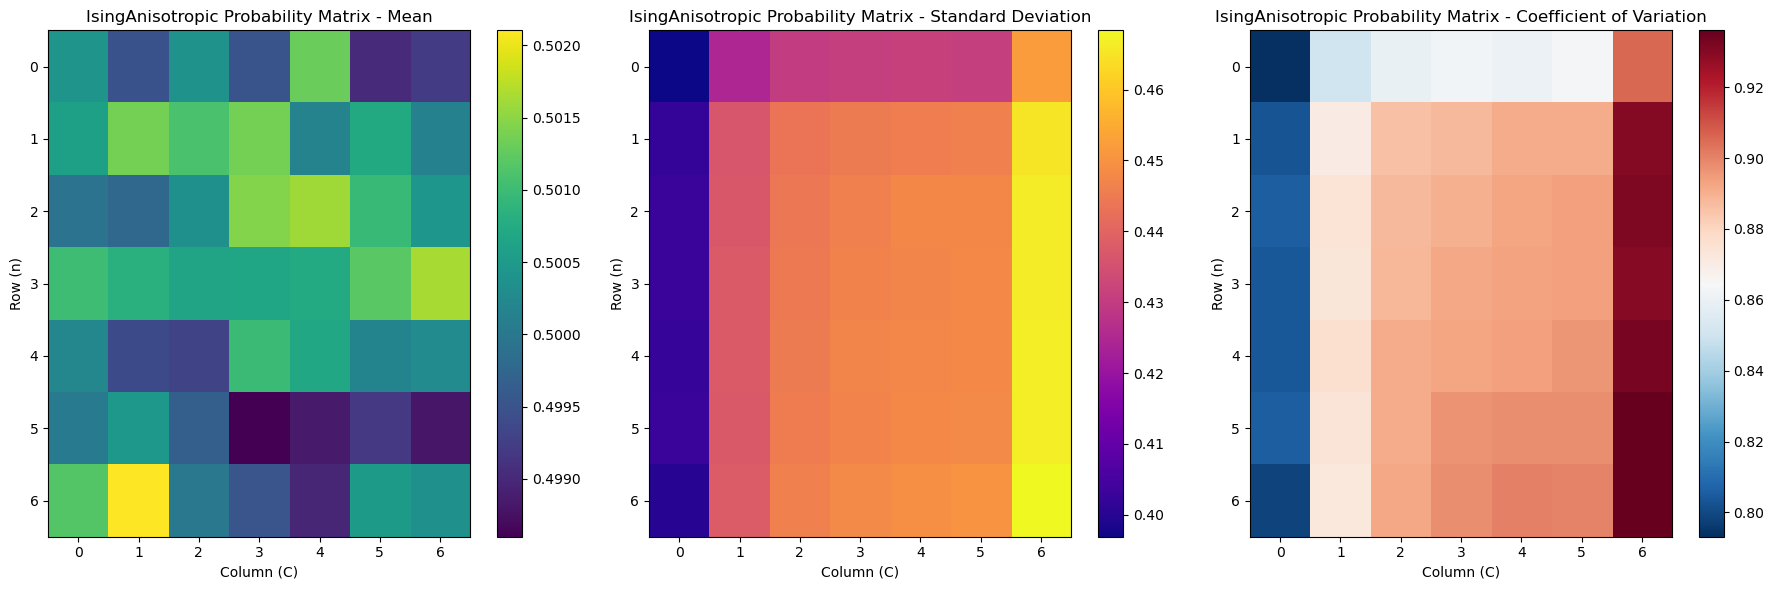


Probability Matrix Summary Statistics:
Mean probability: 0.5003 ± 0.0008
Min probability: 0.4986
Max probability: 0.5021
Mean uncertainty (std): 0.4399 ± 0.0184
Plotting original data for comparison...


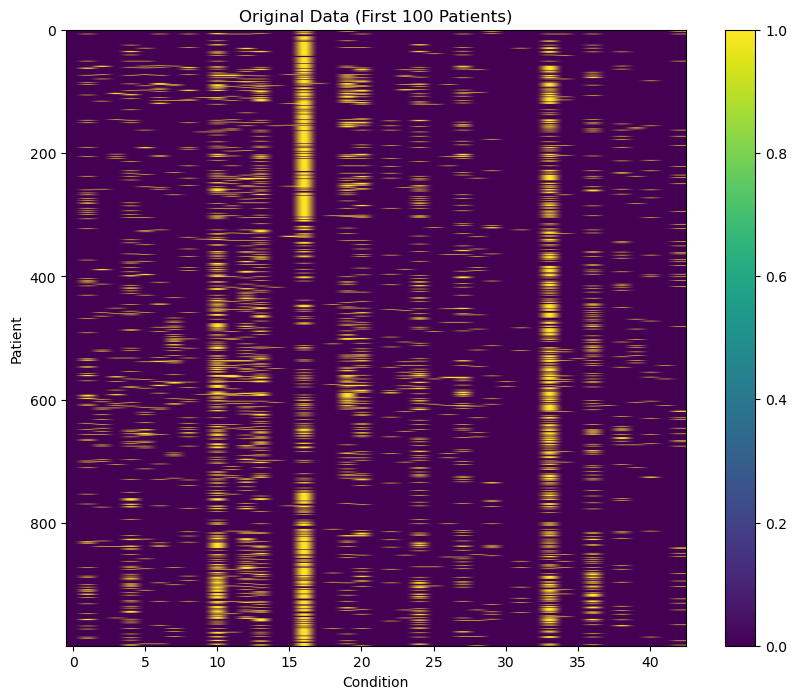

Analysis complete!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import jax
import jax.numpy as jnp
from jax import random
import sys
import os

# Add paths for the required modules
sys.path.append('./Source')
sys.path.append('./_dependency')

from Source.NumpyroDistributions import GMRFDistribution
from dataloader import load_data

def load_mcmc_samples(results_dir_pattern="./Res/gmrf_*"):
    results_dirs = glob.glob(results_dir_pattern)
    if not results_dirs:
        raise FileNotFoundError(f'No results directories found matching pattern: {results_dir_pattern}')
    latest_dir = max(results_dirs, key=Path)
    print(f'Loading MCMC samples from: {latest_dir}')
    mcmc_samples = np.load(f'{latest_dir}/mcmc_samples.npy', allow_pickle=True).item()
    return mcmc_samples

def get_gmrf_posterior_predictives(mcmc_samples, I, C, n_samples=100):
    sigma_samples = mcmc_samples['sigma']
    gamma_samples = mcmc_samples['gamma']
    beta_samples = mcmc_samples['beta']
    key = random.PRNGKey(0)
    pred_samples = []
    for i in range(n_samples):
        idx = np.random.randint(0, len(sigma_samples))
        sigma = float(sigma_samples[idx])
        gamma = float(gamma_samples[idx])
        beta = np.array(beta_samples[idx])
        gmrf_dist = GMRFDistribution(I, C, sigma=sigma, gamma=gamma, beta=beta)
        probs = gmrf_dist.sample(random.fold_in(key, i))
        pred_samples.append(np.array(probs))
    return np.stack(pred_samples)

def plot_estimated_matrix(probs_samples, title="Estimated Probability Matrix"):
    probs_mean = np.mean(probs_samples, axis=0)
    probs_std = np.std(probs_samples, axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    im1 = axes[0].imshow(probs_mean, cmap='viridis', aspect='auto')
    axes[0].set_title(f'{title} - Mean')
    plt.colorbar(im1, ax=axes[0])
    im2 = axes[1].imshow(probs_std, cmap='plasma', aspect='auto')
    axes[1].set_title(f'{title} - Standard Deviation')
    plt.colorbar(im2, ax=axes[1])
    cv = np.where(probs_mean > 0, probs_std / probs_mean, 0)
    im3 = axes[2].imshow(cv, cmap='RdBu_r', aspect='auto')
    axes[2].set_title(f'{title} - Coefficient of Variation')
    plt.colorbar(im3, ax=axes[2])
    plt.tight_layout()
    plt.show()
    print(f'\nProbability Matrix Summary Statistics:')
    print(f'Mean probability: {np.mean(probs_mean):.4f} ± {np.std(probs_mean):.4f}')
    print(f'Min probability: {np.min(probs_mean):.4f}')
    print(f'Max probability: {np.max(probs_mean):.4f}')
    print(f'Mean uncertainty (std): {np.mean(probs_std):.4f} ± {np.std(probs_std):.4f}')
    return probs_mean, probs_std

# Main analysis
print("Loading data and MCMC samples...")
A, X_cov, condition_list = load_data(batch_size=1000)
if A.ndim == 3:
    A_data = A[:, :, 0]
else:
    A_data = A
print(f'Loaded data shape: {A_data.shape}')
n_conditions = A_data.shape[1]
n = int(np.ceil(np.sqrt(n_conditions)))
C = int(np.ceil(n_conditions / n))
print(f'Using grid size: n={n}, C={C} (for {n_conditions} conditions)')
mcmc_samples = load_mcmc_samples(results_dir_pattern="./Res/gmrf_*")
print('Computing posterior predictives...')
probs_samples = get_gmrf_posterior_predictives(mcmc_samples, n, C, n_samples=100)
print(f'Posterior predictive samples shape: {probs_samples.shape}')
print('Plotting estimated probability matrix...')
probs_mean, probs_std = plot_estimated_matrix(probs_samples, 'GMRF Probability Matrix')
print('Plotting original data for comparison...')
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(A_data, cmap='viridis', aspect='auto')
ax.set_title('Original Data (First 1000 Patients)')
ax.set_xlabel('Condition')
ax.set_ylabel('Patient')
plt.colorbar(im, ax=ax)
plt.show()
print('Analysis complete!')

Computing confusion matrix...
Debug info:
  probs_mean shape: (7, 7)
  actual_data shape: (1000, 43)
  n_patients: 1000, n: 7, C: 7
  Padded actual_data with 6 zeros
  actual_data_grid shape after reshape: (1000, 7, 7)
  Final shapes: y_true=(4900,), y_pred_proba=(4900,)
Plotting confusion matrix analysis...


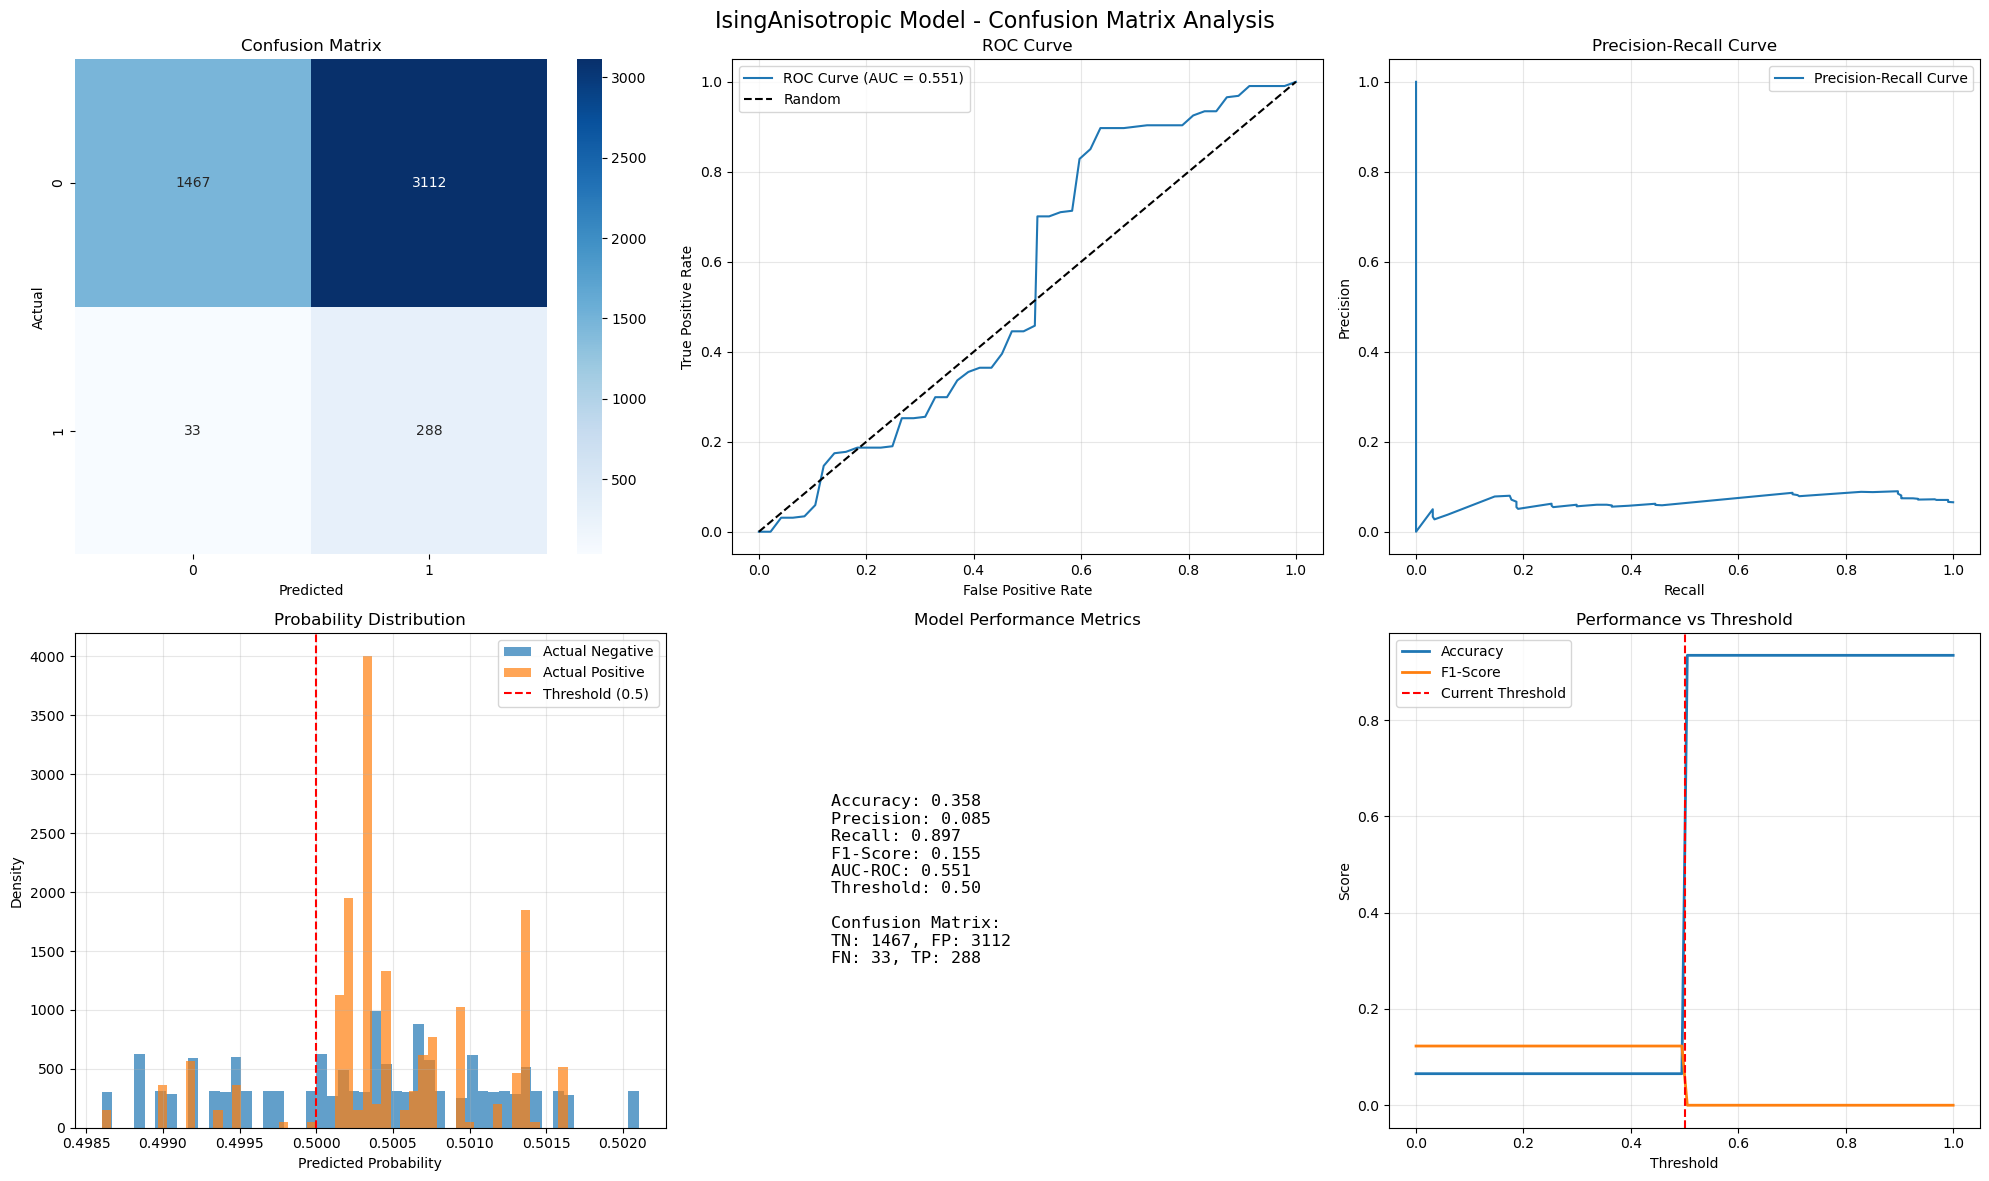


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       0.98      0.32      0.48      4579
    Positive       0.08      0.90      0.15       321

    accuracy                           0.36      4900
   macro avg       0.53      0.61      0.32      4900
weighted avg       0.92      0.36      0.46      4900


THRESHOLD OPTIMIZATION
Debug info:
  probs_mean shape: (7, 7)
  actual_data shape: (1000, 43)
  n_patients: 1000, n: 7, C: 7
  Padded actual_data with 6 zeros
  actual_data_grid shape after reshape: (1000, 7, 7)
  Final shapes: y_true=(4900,), y_pred_proba=(4900,)
Threshold 0.3: F1=0.123, Accuracy=0.066, Precision=0.066, Recall=1.000
Debug info:
  probs_mean shape: (7, 7)
  actual_data shape: (1000, 43)
  n_patients: 1000, n: 7, C: 7
  Padded actual_data with 6 zeros
  actual_data_grid shape after reshape: (1000, 7, 7)
  Final shapes: y_true=(4900,), y_pred_proba=(4900,)
Threshold 0.4: F1=0.123, Accuracy=0.066, Precision=0.066, Reca

In [2]:
# Confusion Matrix Analysis - Fixed Version
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

def compute_confusion_matrix(probs_samples, actual_data, threshold=0.5):
    """
    Compute confusion matrix comparing predicted probabilities with actual data.
    
    Parameters:
    -----------
    probs_samples : np.ndarray
        Posterior predictive samples of shape (n_samples, n, C)
    actual_data : np.ndarray
        Actual observed data of shape (n_patients, n_conditions)
    threshold : float
        Probability threshold for binary classification
        
    Returns:
    --------
    dict : Dictionary containing confusion matrix and metrics
    """
    # Get mean probabilities across posterior samples
    probs_mean = np.mean(probs_samples, axis=0)  # Shape: (n, C)
    
    # Reshape actual data to match the grid structure
    n, C = probs_mean.shape
    n_patients = actual_data.shape[0]
    
    print(f"Debug info:")
    print(f"  probs_mean shape: {probs_mean.shape}")
    print(f"  actual_data shape: {actual_data.shape}")
    print(f"  n_patients: {n_patients}, n: {n}, C: {C}")
    
    # Pad or truncate actual data to match grid size
    grid_size = n * C
    if actual_data.shape[1] > grid_size:
        actual_data_grid = actual_data[:, :grid_size]
        print(f"  Truncated actual_data to {grid_size} conditions")
    else:
        # Pad with zeros if needed
        padding_size = grid_size - actual_data.shape[1]
        padding = np.zeros((actual_data.shape[0], padding_size))
        actual_data_grid = np.concatenate([actual_data, padding], axis=1)
        print(f"  Padded actual_data with {padding_size} zeros")
    
    # Reshape to match the grid structure
    actual_data_grid = actual_data_grid.reshape(n_patients, n, C)
    print(f"  actual_data_grid shape after reshape: {actual_data_grid.shape}")
    
    # Convert actual data from [-1, 1] to [0, 1] if needed
    if np.min(actual_data_grid) < 0:
        actual_data_grid = (actual_data_grid + 1) / 2
        print(f"  Converted actual_data from [-1,1] to [0,1]")
    
    # For each patient, compute the confusion matrix
    all_y_true = []
    all_y_pred_proba = []
    
    for patient in range(min(n_patients, 100)):  # Use first 100 patients
        # Get the patient's actual data
        patient_actual = actual_data_grid[patient, :, :]  # Shape: (n, C)
        
        # Flatten for comparison
        y_true_patient = patient_actual.flatten()  # Shape: (n*C,)
        y_pred_proba_patient = probs_mean.flatten()  # Shape: (n*C,)
        
        all_y_true.extend(y_true_patient)
        all_y_pred_proba.extend(y_pred_proba_patient)
    
    # Convert to numpy arrays
    y_true = np.array(all_y_true)
    y_pred_proba = np.array(all_y_pred_proba)
    y_pred = (y_pred_proba > threshold).astype(int)
    
    print(f"  Final shapes: y_true={y_true.shape}, y_pred_proba={y_pred_proba.shape}")
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Compute additional metrics
    if cm.size == 4:  # 2x2 matrix
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle case where we only have one class
        if cm.size == 1:
            tn, fp, fn, tp = cm[0,0], 0, 0, 0
        else:
            tn, fp, fn, tp = 0, 0, 0, 0
    
    # Calculate metrics
    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Compute AUC-ROC
    try:
        auc_roc = roc_auc_score(y_true, y_pred_proba)
    except:
        auc_roc = np.nan
    
    return {
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc_roc': auc_roc,
        'threshold': threshold
    }

def plot_confusion_matrix_analysis(results, title="Confusion Matrix Analysis"):
    """
    Plot comprehensive confusion matrix analysis.
    """
    cm = results['confusion_matrix']
    y_true = results['y_true']
    y_pred = results['y_pred']
    y_pred_proba = results['y_pred_proba']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # 2. ROC Curve
    try:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        axes[0,1].plot(fpr, tpr, label=f'ROC Curve (AUC = {results["auc_roc"]:.3f})')
        axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random')
        axes[0,1].set_xlabel('False Positive Rate')
        axes[0,1].set_ylabel('True Positive Rate')
        axes[0,1].set_title('ROC Curve')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    except:
        axes[0,1].text(0.5, 0.5, 'ROC Curve\nNot Available', ha='center', va='center')
        axes[0,1].set_title('ROC Curve')
    
    # 3. Precision-Recall Curve
    try:
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        axes[0,2].plot(recall, precision, label='Precision-Recall Curve')
        axes[0,2].set_xlabel('Recall')
        axes[0,2].set_ylabel('Precision')
        axes[0,2].set_title('Precision-Recall Curve')
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
    except:
        axes[0,2].text(0.5, 0.5, 'Precision-Recall\nNot Available', ha='center', va='center')
        axes[0,2].set_title('Precision-Recall Curve')
    
    # 4. Probability Distribution
    if len(np.unique(y_true)) > 1:
        axes[1,0].hist(y_pred_proba[y_true == 0], bins=50, alpha=0.7, label='Actual Negative', density=True)
        axes[1,0].hist(y_pred_proba[y_true == 1], bins=50, alpha=0.7, label='Actual Positive', density=True)
    else:
        axes[1,0].hist(y_pred_proba, bins=50, alpha=0.7, label='All Predictions', density=True)
    axes[1,0].axvline(results['threshold'], color='red', linestyle='--', label=f'Threshold ({results["threshold"]})')
    axes[1,0].set_xlabel('Predicted Probability')
    axes[1,0].set_ylabel('Density')
    axes[1,0].set_title('Probability Distribution')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Metrics Summary
    metrics_text = f"""
    Accuracy: {results['accuracy']:.3f}
    Precision: {results['precision']:.3f}
    Recall: {results['recall']:.3f}
    F1-Score: {results['f1_score']:.3f}
    AUC-ROC: {results['auc_roc']:.3f}
    Threshold: {results['threshold']:.2f}
    
    Confusion Matrix:
    TN: {cm[0,0]}, FP: {cm[0,1]}
    FN: {cm[1,0]}, TP: {cm[1,1]}
    """
    axes[1,1].text(0.1, 0.5, metrics_text, transform=axes[1,1].transAxes, 
                   fontsize=12, verticalalignment='center', fontfamily='monospace')
    axes[1,1].set_title('Model Performance Metrics')
    axes[1,1].axis('off')
    
    # 6. Threshold Analysis
    thresholds = np.linspace(0, 1, 100)
    accuracies = []
    f1_scores = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba > thresh).astype(int)
        cm_thresh = confusion_matrix(y_true, y_pred_thresh)
        if cm_thresh.size == 4:
            tn, fp, fn, tp = cm_thresh.ravel()
            acc = (tp + tn) / (tp + tn + fp + fn)
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        else:
            acc = f1 = 0
        accuracies.append(acc)
        f1_scores.append(f1)
    
    axes[1,2].plot(thresholds, accuracies, label='Accuracy', linewidth=2)
    axes[1,2].plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
    axes[1,2].axvline(results['threshold'], color='red', linestyle='--', label=f'Current Threshold')
    axes[1,2].set_xlabel('Threshold')
    axes[1,2].set_ylabel('Score')
    axes[1,2].set_title('Performance vs Threshold')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification report
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
    
    return results

# Compute confusion matrix
print("Computing confusion matrix...")
confusion_results = compute_confusion_matrix(probs_samples, A_data, threshold=0.5)

# Plot comprehensive analysis
print("Plotting confusion matrix analysis...")
plot_confusion_matrix_analysis(confusion_results, "IsingAnisotropic Model - Confusion Matrix Analysis")

# Additional analysis: Try different thresholds
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds_to_test:
    results = compute_confusion_matrix(probs_samples, A_data, threshold=threshold)
    print(f"Threshold {threshold:.1f}: F1={results['f1_score']:.3f}, "
          f"Accuracy={results['accuracy']:.3f}, "
          f"Precision={results['precision']:.3f}, "
          f"Recall={results['recall']:.3f}")
    
    if results['f1_score'] > best_f1:
        best_f1 = results['f1_score']
        best_threshold = threshold

print(f"\nBest threshold: {best_threshold:.1f} (F1 = {best_f1:.3f})")

# Plot with best threshold
if best_threshold != 0.5:
    print(f"\nPlotting analysis with optimal threshold ({best_threshold:.1f})...")
    best_results = compute_confusion_matrix(probs_samples, A_data, threshold=best_threshold)
    plot_confusion_matrix_analysis(best_results, f"IsingAnisotropic Model - Optimal Threshold ({best_threshold:.1f})")

print("Confusion matrix analysis complete!")